<a href="https://colab.research.google.com/github/aobd1356/Homework/blob/main/Report05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 專案報告: Hololive 0期生 喜好投票

## 專案背景與動機

### 專案背景  
我是個很喜歡Vtuber的人，特別喜歡Hololive的0期生，我想透過本次專案來做調查，調查大家比較喜歡哪一位0期生。
### 專案目標  
- 輸入carousel可以開啟投票頁面，每一頁代表一個人，分別有名字，相片，基本資料，維基網站，Youtube連結，以及投票選項，當我們投票完會顯示你投給誰，若重複投票會顯示你已經投過了。  
- 輸入result會顯示單前投票結果以及現在誰的票數最高。

## 系統設計與架構

### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | 使用者透過 LINE 傳送訊息，Bot 接收並處理 |
| 回應傳送 | Bot 將 Gemini 的回應以文字方式回傳給使用者 |
| 基本指令處理 | 回覆「幫助」等內建說明指令，提供使用說明 |
| 錯誤處理 | 在 API 異常或超時時提供提示訊息 |
| 功能名稱                  | 說明                                                      |
| --------------------- | ------------------------------------------------------- |
| Carousel 投票 UI | 使用 `CarouselTemplate` 呈現多個 Vtuber 卡片，含圖片、說明與投票按鈕，介面互動性高 |
| Postback 投票處理  | 將投票按鈕改為 `PostbackAction`，比 MessageAction 更專業，也能避免重複觸發訊息 |
| 單人限投一次 | 使用 user ID 限制每位使用者只能投一次，避免灌票                            |
| 即時票數統計 | 使用者輸入 `result` 可即時看到每位 Vtuber 的票數與目前最高票者                |
| 邏輯分流處理 | 根據使用者輸入文字動態切換：文字訊息處理 vs 投票 vs 顯示結果，模組化設計良好              |

### 系統架構圖


### 使用的技術  

| 技術項目       | 說明  |
| ---------- | ------------------------------------------------------- |
| 程式語言 | Python |
| 框架 | Flask（建立 webhook）  |
| 部署平台 | Vercel |
| API 使用 | LINE Messaging API（對話） |
| 資料格式 | JSON 處理傳輸與接收資料 |
| 外部工具 | pyngrok（用於將本地開發環境暴露到互聯網，僅在開發階段使用）|
| 互動界面 | 使用 LINE Bot 的模板（CarouselTemplate、ConfirmTemplate）提供投票介面 |


## 專案成果與效益

### 系統程式

In [1]:
!pip install -q pyngrok flask_ngrok # for colab
!pip install -q flask line-bot-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.1/776.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 10.1 MB/s eta 0:00:00


In [2]:
# for colab
from google.colab import userdata
from pyngrok import ngrok
from flask_ngrok import run_with_ngrok

def ngrok_start():
    ngrok.set_auth_token(userdata.get('NGROK_AUTHTOKEN'))
    ngrok.connect(5000)
    run_with_ngrok(app)

from flask import Flask, request, abort
from collections import defaultdict

from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.webhooks import MessageEvent, TextMessageContent, PostbackEvent
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi,
    ReplyMessageRequest,
    TextMessage,
    TemplateMessage, ConfirmTemplate, MessageAction,
    CarouselTemplate,
    CarouselColumn,
    URIAction,
    PostbackAction
)

app = Flask(__name__)

configuration = Configuration(access_token=userdata.get('access_token'))
handler = WebhookHandler(userdata.get('Channel_secret'))

# 記錄投票資料
vote_counts = defaultdict(int)
voter_ids = set()

@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'

@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)

        action = event.message.text
        if action == "confirm":
            template = ConfirmTemplate(
                text="你喜歡Hololive嗎？",
                actions=[
                    MessageAction(label="是", text="我很喜歡"),
                    MessageAction(label="否", text="其實我超級喜歡")
                ]
            )
            reply = TemplateMessage(
                alt_text="這是確認視窗",
                template=template
            )
        elif action == 'carousel':
            carousel_template = CarouselTemplate(
                columns=[
                    CarouselColumn(
                        thumbnail_image_url='https://th.bing.com/th/id/OIP.qt6SgN5YB3v5MRGiI9eArQHaHE?rs=1&pid=ImgDetMain',
                        title='櫻巫女',
                        text='日本vtuber',
                        actions=[
                            URIAction(label='維基百科', uri='https://zh.wikipedia.org/zh-tw/%E6%A8%B1%E5%B7%AB%E5%A5%B3'),
                            URIAction(label='YOUTUBE', uri='https://www.youtube.com/@SakuraMiko'),
                            PostbackAction(label="投票", data="action=add&item=SakuraMiko")
                        ]
                    ),
                    CarouselColumn(
                        thumbnail_image_url='https://th.bing.com/th/id/OIP.MB5CwVjIhdiPMMJ5FJhKqAHaI4?rs=1&pid=ImgDetMain',
                        title='星街彗星',
                        text='日本vtuber',
                        actions=[
                            URIAction(label='維基百科', uri='https://zh.wikipedia.org/wiki/%E6%98%9F%E8%A1%97%E5%BD%97%E6%98%9F'),
                            URIAction(label='YOUTUBE', uri='https://www.youtube.com/@HoshimachiSuisei'),
                            PostbackAction(label="投票", data="action=add&item=HoshimachiSuisei")
                        ]
                    ),
                    CarouselColumn(
                        thumbnail_image_url='https://static.wikitide.net/hololivewiki/thumb/0/0f/Tokino_Sora_-_Portrait_06-1.png/1200px-Tokino_Sora_-_Portrait_06-1.png',
                        title='時乃空',
                        text='日本vtuber',
                        actions=[
                            URIAction(label='維基百科', uri='https://zh.wikipedia.org/zh-tw/%E6%97%B6%E4%B9%83%E7%A9%BA'),
                            URIAction(label='YOUTUBE', uri='https://www.youtube.com/@TokinoSora'),
                            PostbackAction(label="投票", data="action=add&item=TokinoSora")
                        ]
                    ),
                    CarouselColumn(
                        thumbnail_image_url='https://th.bing.com/th/id/OIP.22cG3WskWYLwxBTxC3pgZAHaHa?rs=1&pid=ImgDetMain',
                        title='AZKi',
                        text='日本vtuber',
                        actions=[
                            URIAction(label='維基百科', uri='https://zh.wikipedia.org/zh-tw/AZKi'),
                            URIAction(label='YOUTUBE', uri='https://www.youtube.com/@AZKi'),
                            PostbackAction(label="投票", data="action=add&item=AZKi")
                        ]
                    ),
                    CarouselColumn(
                        thumbnail_image_url='https://zh.wikipedia.org/zh-tw/%E8%90%9D%E5%8D%9C%E5%AD%90#/media/File:%E8%98%BF%E8%94%94%E5%AD%90.png',
                        title='蘿蔔子',
                        text='日本vtuber',
                        actions=[
                            URIAction(label='維基百科', uri='https://zh.wikipedia.org/zh-tw/%E8%90%9D%E5%8D%9C%E5%AD%90'),
                            URIAction(label='YOUTUBE', uri='https://www.youtube.com/@Robocosan'),
                            PostbackAction(label="投票", data="action=add&item=Robocosan")
                        ]
                    )
                ]
            )
            reply = TemplateMessage(
                alt_text="這是輪播視窗",
                template=carousel_template
            )
        elif action == 'result':
            if vote_counts:
                result_lines = [f"{name}：{count} 票" for name, count in vote_counts.items()]
                max_votes = max(vote_counts.values())
                leaders = [name for name, count in vote_counts.items() if count == max_votes]
                if len(leaders) == 1:
                    result_lines.append(f"目前領先：{leaders[0]}")
                else:
                    result_lines.append("目前是平手")
                result_text = "投票統計\n" + "\n".join(result_lines)
            else:
                result_text = "目前沒有投票資料"
            reply = TextMessage(text=result_text)
        else:
            reply = TextMessage(text=event.message.text)

        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[reply]
            )
        )

@handler.add(PostbackEvent)
def handle_postback(event):
    with ApiClient(configuration) as api_client:
        data = event.postback.data
        user_id = event.source.user_id

        item_map = {
            "SakuraMiko": "櫻巫女",
            "HoshimachiSuisei": "星街彗星",
            "TokinoSora": "時乃空",
            "AZKi": "AZKi",
            "Robocosan": "蘿蔔子"
        }

        item_id = data.split("item=")[-1] if "item=" in data else None
        item_name = item_map.get(item_id, "未知角色")

        if user_id in voter_ids:
            reply_message = TextMessage(text=f"你已經投過票囉！")
        else:
            vote_counts[item_name] += 1
            voter_ids.add(user_id)
            reply_message = TextMessage(text=f"你投票給了：{item_name}")

        line_bot_api = MessagingApi(api_client)
        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[reply_message]
            )
        )

ngrok_start()  # for colab

if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://6ee1-34-44-213-1.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:32:47] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:33:49] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:34:25] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:34:59] "POST /callback HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:35:13] "POST /callback HTTP/1.1" 200 -


### 系統畫面

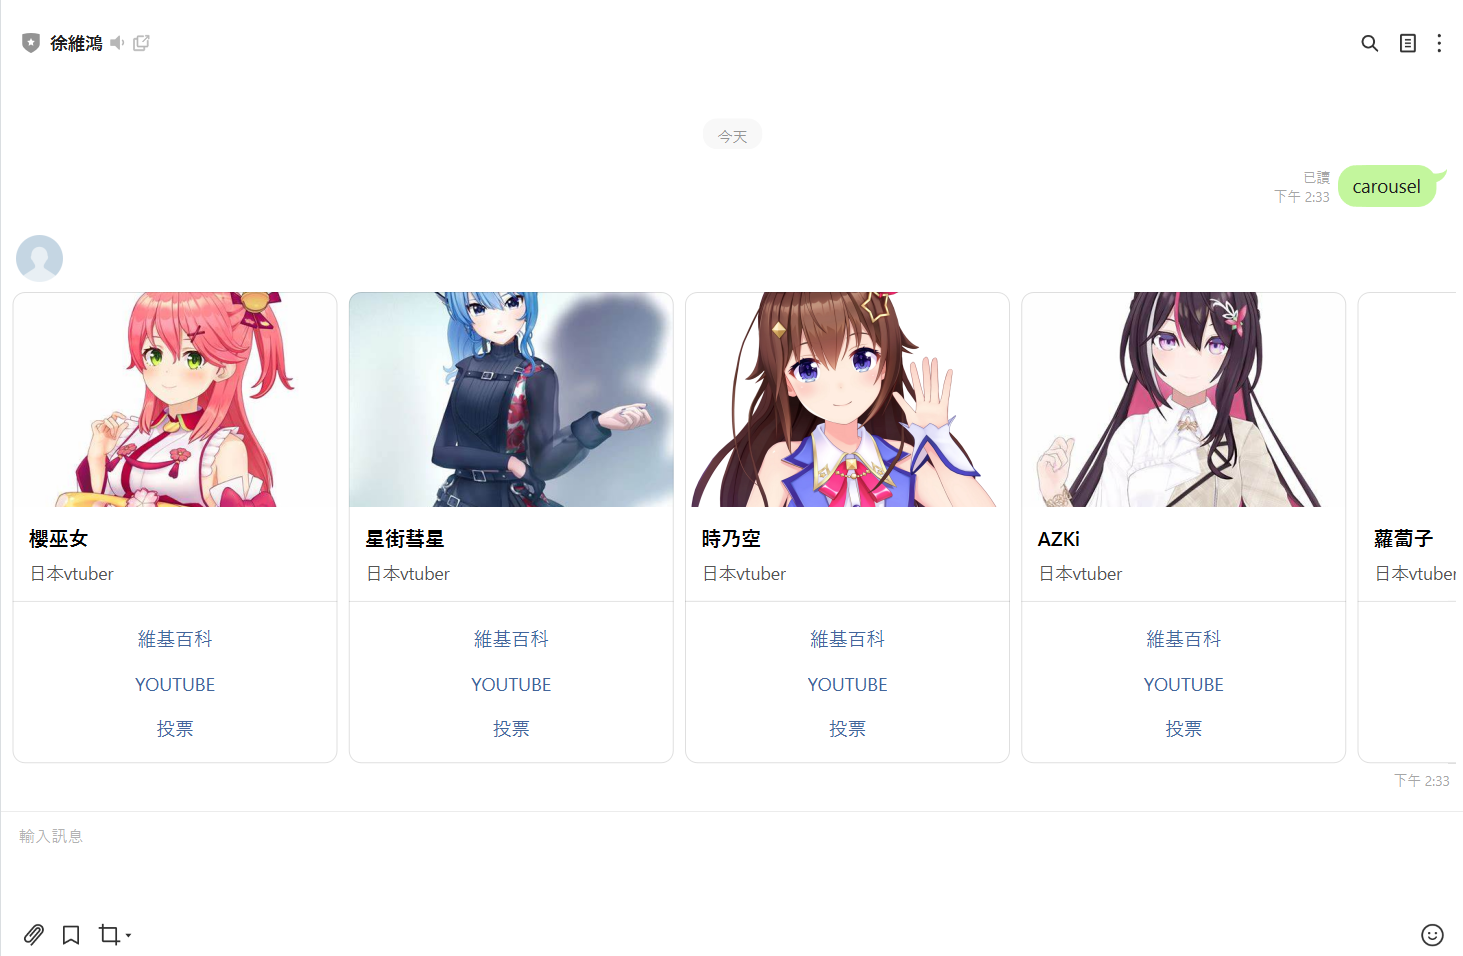

輸入carousel顯示頁面，此頁面可以進行投票檢視維基百科和youtube頻道

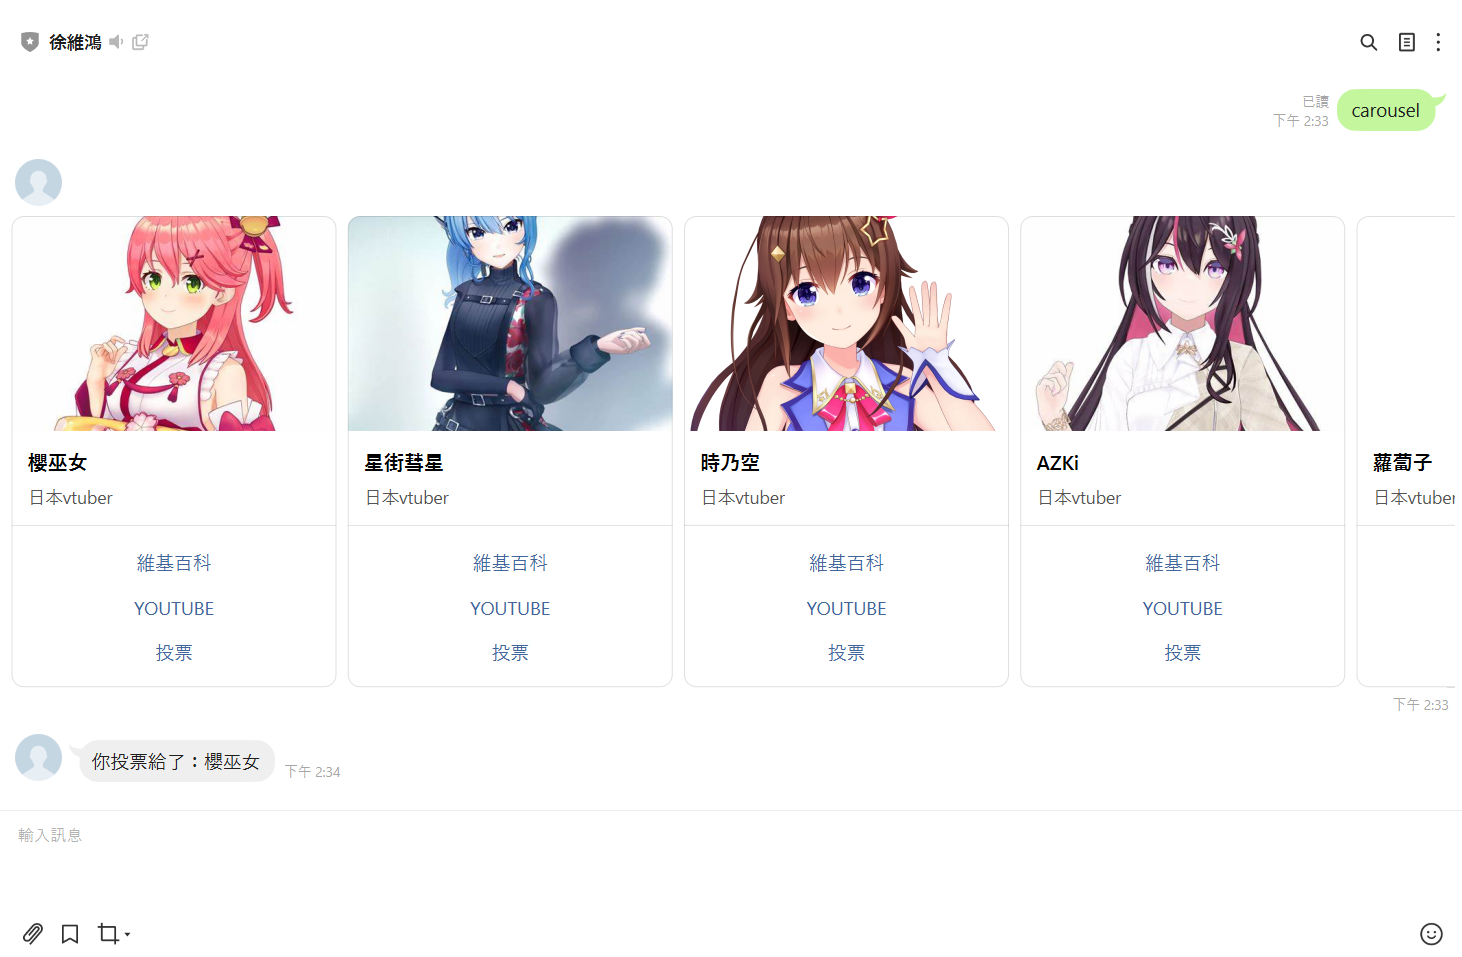

按下投票會顯示你投給誰了

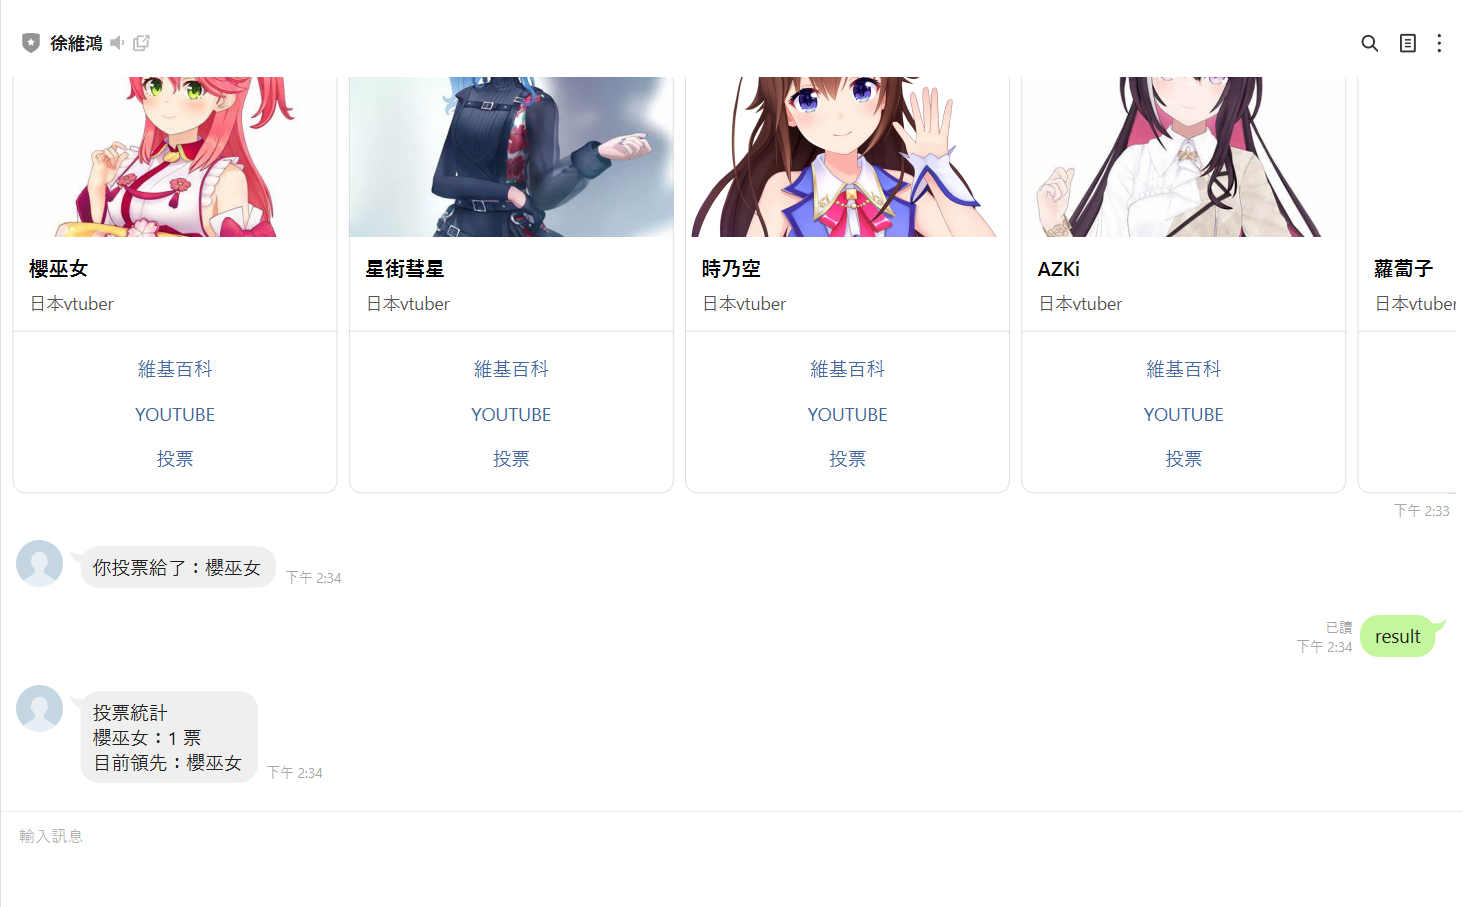

輸入result顯示現在有幾人投票，誰領先

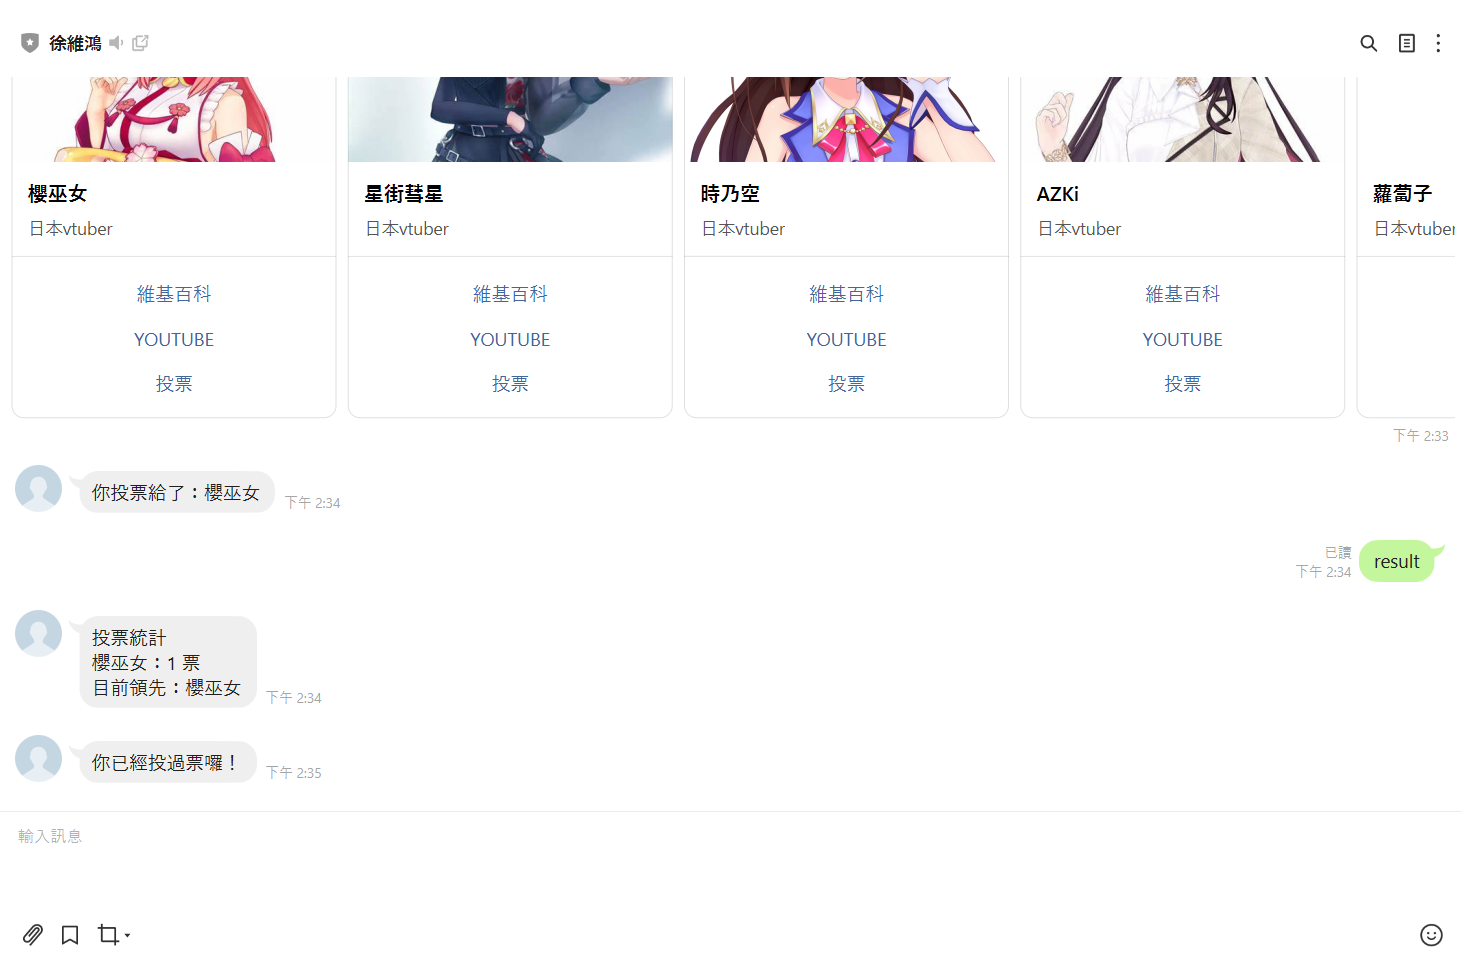

如果再次投票會顯示你已經投過票了

### 效益分析

- 使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 圖片顯示正確 | 100% 滿意 | 能顯示全部的圖片 |
| 界面設計 | 95% 滿意 | 使用者喜歡 LINE 的簡潔界面 |


- 系統是否達到目標？  
是。系統成功讓使用者了解我所寫的選項，並開啟投票讓大家投票，最後也成功顯示投票結果，所以十分成功。

## 未來發展與改進

### 改進建議  
- 加入更多選項
- 美化介面，使介面更美觀
- 不用輸入任何字就可以顯示投票並投完票直接顯示當時投票結果
- 做一個含有截止時間的投票，若時間到即停止投票並結算結果

### 未來規劃  
- 改善介面  
- 投票結果透過圖表展示
- 自己設定命令，不用統一使用向result這種固定的回應\